<a href="https://colab.research.google.com/github/ashahdeen/MAIZE-CROP-DISEASE-IMAGE-CLASSIFICATION/blob/dev-branch/maize_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#loading libraries.
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#keras libraries
import keras


#libraries for loading images
from pathlib import Path
import pathlib
import PIL
import PIL.Image

import cv2


###Loading the dataset.

In [3]:
#path to get document from drive.
p = Path("/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images") 

# downloading our dataset

data_dir= pathlib.Path(p)
data_dir

PosixPath('/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images')

###Checking our Dataset

In [4]:
# The total number of images present
image_counts = len(list(data_dir.glob('*/*')))
print(image_counts)

3076


In [5]:
#total number of images in head smut
smut_count = len(list(data_dir.glob('SMUT500/*')))
print(smut_count)

566


In [6]:
#total number of images in head smut
healthy_count = len(list(data_dir.glob('healthy/*')))
print(healthy_count)

530


In [7]:
#total number of images in Common_rust.
rust_count = len(list(data_dir.glob('Common_rust/*')))
print(rust_count)

596


In [8]:
#total number of images in maize streak.
streak_count = len(list(data_dir.glob('maizestreak_aug/*')))
print(streak_count)

416


In [9]:
#total number of images in Common_rust.
rust_count = len(list(data_dir.glob('Common_rust/*')))
print(rust_count)

596


In [10]:
#total number of images in Common_rust.
gray_count = len(list(data_dir.glob('Gray Leaf Spot/*')))
print(gray_count)

470


In [11]:
#total number of images in Common_rust.
Northern_count = len(list(data_dir.glob('Blight/*')))
print(Northern_count)

498


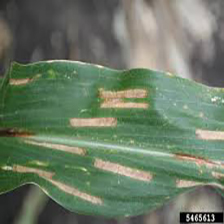

In [12]:
# Previewing the images of a Gray Leaf Spot
Gray_leaf= list(data_dir.glob('Gray Leaf Spot/*'))
PIL.Image.open(str(Gray_leaf[5]))

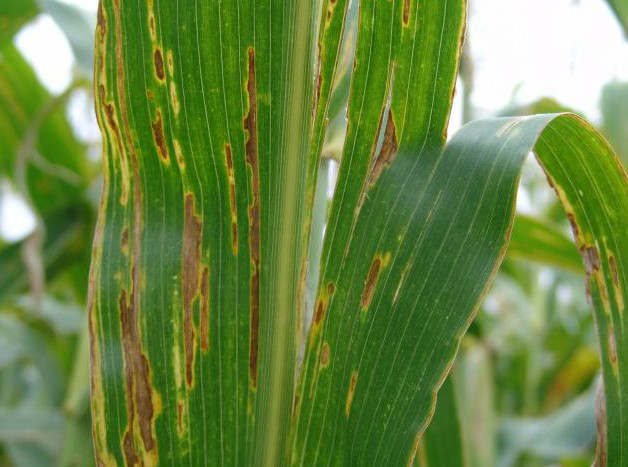

In [13]:
# Previewing the images of a Northern Blight
North_count= list(data_dir.glob('Blight/*'))
PIL.Image.open(str(North_count[4]))

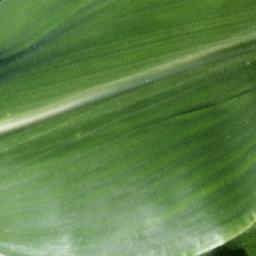

In [14]:
# Previewing the images of a healthy
healthy_count= list(data_dir.glob('healthy/*'))
PIL.Image.open(str(healthy_count[5]))

###Data Preprocessing.


In [15]:
#creating data and resizing our images
batch_size = 32
img_height = 180
img_width = 180

In [16]:
#validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3076 files belonging to 6 classes.
Using 615 files for validation.


In [17]:
#training set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3076 files belonging to 6 classes.
Using 2461 files for training.


In [18]:
# Class name attributes on our dataset
class_names = train_ds.class_names
print(class_names)

['Blight', 'Common_rust', 'Gray Leaf Spot', 'SMUT500', 'healthy', 'maizestreak_aug']


In [19]:
# Iterating over our dataset to retrieve images
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [20]:
#catcheing our data so that it can be saved to our first epoch.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [22]:
#normalizing from RBG of range[0,255] to range [0,1] to make it ideal for neural network 
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [23]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# # Notice the pixels values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

###Wandb

In [24]:
%%capture
!pip install wandb

In [25]:
import wandb

In [26]:
wandb.login()

wandb: Currently logged in as: mo_g (use `wandb login --relogin` to force relogin)


True

In [27]:
def Model():
  #inputs = keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  inputs = keras.layers.Input(shape=(180, 180, 3))
  
  x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inputs)
  x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
  x = keras.layers.MaxPooling2D(pool_size=2)(x)

  x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
  x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)

  x = keras.layers.GlobalAveragePooling2D()(x)

  x = keras.layers.Dense(128, activation='relu')(x)
  x = keras.layers.Dense(32, activation='relu')(x)
  
  outputs = keras.layers.Dense(6, activation='softmax')(x)

  return keras.models.Model(inputs=inputs, outputs=outputs)

In [28]:
# Initialize wandb with your project name
run = wandb.init(project='maize-image-classification',save_code=True,name='balanced classes',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.001,
                     "epochs": 10,
                     "batch_size": 1024,
                     "loss_function": "sparse_categorical_crossentropy",
                     "architecture": "CNN four layers",
                     "dataset": "maize-images"
                 })
config = wandb.config  # We'll use this to configure our experiment

# Initialize model like you usually do.
tf.keras.backend.clear_session()
model = Model()
model.summary()

# Compile model like you usually do.
# Notice that we use config, so our metadata matches what gets executed
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
model.compile(optimizer, config.loss_function, metrics=['acc'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 176, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 88, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 86, 86, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 84, 84, 32)        9248      
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0     

In [29]:
# import wandcallback 
from wandb.keras import WandbCallback

In [30]:
# We train with our model.fit
# WandbCallback is used as a regular callback
# We again use config
history= model.fit(train_ds,
          epochs=config.epochs, 
          batch_size=config.batch_size,
          validation_data=(val_ds),
          callbacks=[WandbCallback()])

Epoch 1/10
77/77 [==============================] - 14s 145ms/step - loss: 1.6304 - acc: 0.3763 - val_loss: 1.1428 - val_acc: 0.5496
Epoch 2/10
77/77 [==============================] - 8s 107ms/step - loss: 1.0463 - acc: 0.6014 - val_loss: 0.9842 - val_acc: 0.6049
Epoch 3/10
77/77 [==============================] - 8s 106ms/step - loss: 0.9510 - acc: 0.6241 - val_loss: 0.9020 - val_acc: 0.6423
Epoch 4/10
77/77 [==============================] - 8s 107ms/step - loss: 0.9187 - acc: 0.6518 - val_loss: 0.8929 - val_acc: 0.6553
Epoch 5/10
77/77 [==============================] - 8s 107ms/step - loss: 0.8734 - acc: 0.6619 - val_loss: 0.8277 - val_acc: 0.6797
Epoch 6/10
77/77 [==============================] - 8s 106ms/step - loss: 0.8480 - acc: 0.6847 - val_loss: 0.7762 - val_acc: 0.7057
Epoch 7/10
77/77 [==============================] - 8s 106ms/step - loss: 0.7895 - acc: 0.6989 - val_loss: 0.7636 - val_acc: 0.7138
Epoch 8/10
77/77 [==============================] - 8s 107ms/step - loss: 0

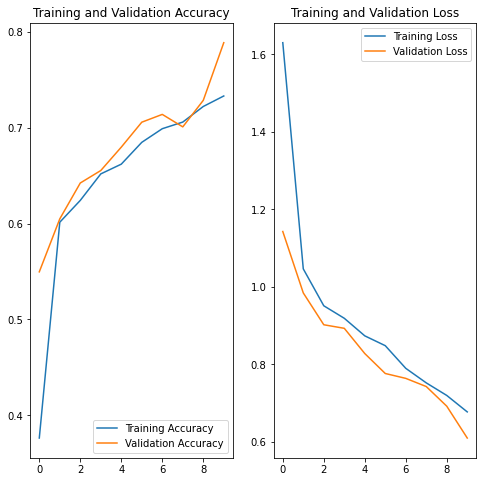

In [31]:
# Creating plots of loss and accuracy on the training and validation sets.
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(config.epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Improving our model by first increasing the epochs from 10 to 20

In [32]:
# Initialize wandb with your project name
run = wandb.init(project='maize-image-classification',save_code=True,name='b with increased epoch',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.001,
                     "epochs": 20,
                     "batch_size": 1024,
                     "loss_function": "sparse_categorical_crossentropy",
                     "architecture": "CNN four layers",
                     "dataset": "maize-images"
                 })
config = wandb.config  # We'll use this to configure our experiment

# Initialize model like you usually do.
tf.keras.backend.clear_session()
model = Model()
model.summary()

# Compile model like you usually do.
# Notice that we use config, so our metadata matches what gets executed
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
model.compile(optimizer, config.loss_function, metrics=['acc'])

acc,0.73304
best_epoch,9
best_val_loss,0.6095
epoch,9
loss,0.67696
val_acc,0.78862
val_loss,0.6095


acc,▁▅▆▆▇▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▂▁▁
val_acc,▁▃▄▄▅▆▆▅▆█
val_loss,█▆▅▅▄▃▃▃▂▁


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 176, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 88, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 86, 86, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 84, 84, 32)        9248      
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0     

In [33]:
# We train with our model.fit
# WandbCallback is used as a regular callback
# We again use config
history= model.fit(train_ds,
          epochs=config.epochs, 
          batch_size=config.batch_size,
          validation_data=(val_ds),
          callbacks=[WandbCallback()])

Epoch 1/20
77/77 [==============================] - 9s 110ms/step - loss: 1.3323 - acc: 0.4856 - val_loss: 1.0047 - val_acc: 0.6211
Epoch 2/20
77/77 [==============================] - 8s 107ms/step - loss: 0.9833 - acc: 0.6119 - val_loss: 0.8458 - val_acc: 0.6699
Epoch 3/20
77/77 [==============================] - 8s 106ms/step - loss: 0.8750 - acc: 0.6664 - val_loss: 0.8179 - val_acc: 0.6927
Epoch 4/20
77/77 [==============================] - 8s 106ms/step - loss: 0.8642 - acc: 0.6648 - val_loss: 0.8042 - val_acc: 0.6829
Epoch 5/20
77/77 [==============================] - 8s 107ms/step - loss: 0.8180 - acc: 0.6798 - val_loss: 0.7607 - val_acc: 0.6992
Epoch 6/20
77/77 [==============================] - 8s 107ms/step - loss: 0.8061 - acc: 0.6896 - val_loss: 0.7037 - val_acc: 0.7187
Epoch 7/20
77/77 [==============================] - 8s 107ms/step - loss: 0.7398 - acc: 0.7095 - val_loss: 0.7236 - val_acc: 0.7382
Epoch 8/20
77/77 [==============================] - 8s 107ms/step - loss: 0.

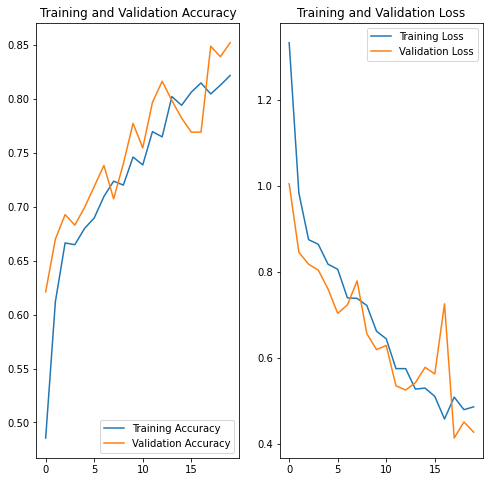

In [34]:
# Creating plots of loss and accuracy on the training and validation sets.
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(config.epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

There is an improvement in the model after increasing the epochs from 10 to 20.

We will increase the layers in our model to increase accuracy.

In [35]:
def Model():
  #inputs = keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  inputs = keras.layers.Input(shape=(180, 180, 3))
  
  x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inputs)
  x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
  x = keras.layers.MaxPooling2D(pool_size=2)(x)

  x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
  x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
  x = keras.layers.MaxPooling2D(pool_size=2)(x)

  x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
  x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
  
  x = keras.layers.GlobalAveragePooling2D()(x)

  x = keras.layers.Dense(128, activation='relu')(x)
  x = keras.layers.Dense(32, activation='relu')(x)
  
  outputs = keras.layers.Dense(6, activation='softmax')(x)

  return keras.models.Model(inputs=inputs, outputs=outputs)

In [36]:
# Initialize wandb with your project name
run = wandb.init(project='maize-image-classification',save_code=True,name='b with increased layers',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.001,
                     "epochs": 20,
                     "batch_size": 1024,
                     "loss_function": "sparse_categorical_crossentropy",
                     "architecture": "CNN four layers",
                     "dataset": "maize-images"
                 })
config = wandb.config  # We'll use this to configure our experiment

# Initialize model like you usually do.
tf.keras.backend.clear_session()
model = Model()
model.summary()

# Compile model like you usually do.
# Notice that we use config, so our metadata matches what gets executed
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
model.compile(optimizer, config.loss_function, metrics=['acc'])

acc,0.82162
best_epoch,17
best_val_loss,0.41431
epoch,19
loss,0.48673
val_acc,0.85203
val_loss,0.42801


acc,▁▄▅▅▅▅▆▆▆▆▆▇▇█▇█████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
val_acc,▁▂▃▃▃▄▅▄▅▆▅▆▇▆▆▅▅███
val_loss,█▆▆▆▅▄▅▅▄▃▄▂▂▃▃▃▅▁▁▁


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 176, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 88, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 86, 86, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 84, 84, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 32)        0     

In [37]:
# We train with our model.fit
# WandbCallback is used as a regular callback
# We again use config
history= model.fit(train_ds,
          epochs=config.epochs, 
          batch_size=config.batch_size,
          validation_data=(val_ds),
          callbacks=[WandbCallback()])

Epoch 1/20
77/77 [==============================] - 10s 119ms/step - loss: 1.5916 - acc: 0.3840 - val_loss: 1.2461 - val_acc: 0.4504
Epoch 2/20
77/77 [==============================] - 9s 115ms/step - loss: 1.0805 - acc: 0.5664 - val_loss: 0.9468 - val_acc: 0.6260
Epoch 3/20
77/77 [==============================] - 9s 115ms/step - loss: 0.9725 - acc: 0.6258 - val_loss: 0.9319 - val_acc: 0.6455
Epoch 4/20
77/77 [==============================] - 9s 115ms/step - loss: 0.9544 - acc: 0.6144 - val_loss: 0.9048 - val_acc: 0.6488
Epoch 5/20
77/77 [==============================] - 9s 114ms/step - loss: 0.8557 - acc: 0.6664 - val_loss: 0.7870 - val_acc: 0.7024
Epoch 6/20
77/77 [==============================] - 9s 114ms/step - loss: 0.7677 - acc: 0.7001 - val_loss: 0.7647 - val_acc: 0.7089
Epoch 7/20
77/77 [==============================] - 9s 114ms/step - loss: 0.7617 - acc: 0.7107 - val_loss: 0.7086 - val_acc: 0.7268
Epoch 8/20
77/77 [==============================] - 9s 114ms/step - loss: 0

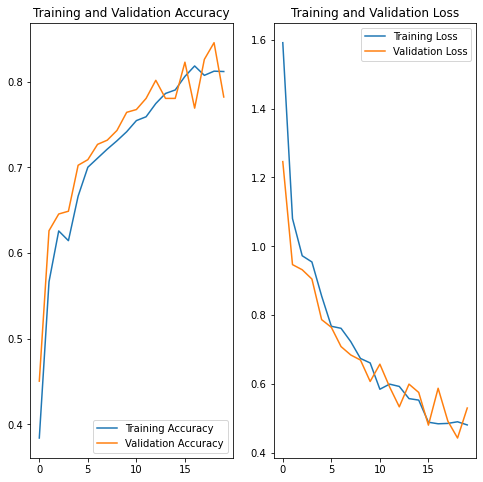

In [38]:
# Creating plots of loss and accuracy on the training and validation sets.
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(config.epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We will also improve our model by increasing the learning rate from 0.001 to 0.01.

In [39]:
# Initialize wandb with your project name
run = wandb.init(project='maize-image-classification',save_code=True,name='b with increased learning rate',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.01,
                     "epochs": 20,
                     "batch_size": 1024,
                     "loss_function": "sparse_categorical_crossentropy",
                     "architecture": "CNN four layers",
                     "dataset": "maize-images"
                 })
config = wandb.config  # We'll use this to configure our experiment

# Initialize model like you usually do.
tf.keras.backend.clear_session()
model = Model()
model.summary()

# Compile model like you usually do.
# Notice that we use config, so our metadata matches what gets executed
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
model.compile(optimizer, config.loss_function, metrics=['acc'])

acc,0.81187
best_epoch,18
best_val_loss,0.44291
epoch,19
loss,0.48098
val_acc,0.78211
val_loss,0.53013


acc,▁▄▅▅▆▆▆▆▇▇▇▇▇▇██████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,▁▄▄▅▅▆▆▆▆▇▇▇▇▇▇█▇██▇
val_loss,█▅▅▅▄▄▃▃▃▂▃▂▂▂▂▁▂▁▁▂


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 176, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 88, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 86, 86, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 84, 84, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 32)        0     

In [40]:
# We train with our model.fit
# WandbCallback is used as a regular callback
# We again use config
history= model.fit(train_ds,
          epochs=config.epochs, 
          batch_size=config.batch_size,
          validation_data=(val_ds),
          callbacks=[WandbCallback()])

Epoch 1/20
77/77 [==============================] - 10s 115ms/step - loss: 1.7099 - acc: 0.3178 - val_loss: 1.4016 - val_acc: 0.4488
Epoch 2/20
77/77 [==============================] - 9s 113ms/step - loss: 1.2302 - acc: 0.5095 - val_loss: 1.0872 - val_acc: 0.5691
Epoch 3/20
77/77 [==============================] - 9s 114ms/step - loss: 1.0641 - acc: 0.5697 - val_loss: 1.0444 - val_acc: 0.6049
Epoch 4/20
77/77 [==============================] - 9s 113ms/step - loss: 1.0358 - acc: 0.5924 - val_loss: 1.0116 - val_acc: 0.5789
Epoch 5/20
77/77 [==============================] - 9s 113ms/step - loss: 0.9509 - acc: 0.6197 - val_loss: 0.9006 - val_acc: 0.6650
Epoch 6/20
77/77 [==============================] - 9s 112ms/step - loss: 0.8997 - acc: 0.6237 - val_loss: 0.8928 - val_acc: 0.6650
Epoch 7/20
77/77 [==============================] - 9s 112ms/step - loss: 0.9207 - acc: 0.6319 - val_loss: 1.2382 - val_acc: 0.5041
Epoch 8/20
77/77 [==============================] - 9s 112ms/step - loss: 0

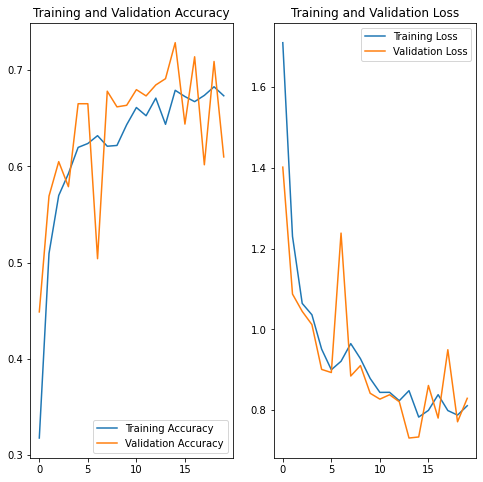

In [41]:
# Creating plots of loss and accuracy on the training and validation sets.
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(config.epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Improving accuracy by performing transfer learning


## Transfer Learning

###Transfer Learning Model 1: MobileNetV2.



In [65]:
## Create the base model from the pre-trained model MobileNet V2

image_size=(img_height, img_width)
IMG_SHAPE = image_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# let's see our batch of images that have gone through feature extraction
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

#Freeze convolutional layer
base_model.trainable = False

# Add classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)


#  # build model
# inputs = tf.keras.Input(shape=(180, 180, 3))
# #  x = data_augmentation(inputs)
# x = normalization_layer(x)
# x = base_model(x)
# x = global_average_layer(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# outputs = prediction_layer(x)
# model = tf.keras.Model(inputs, outputs)
# model = Model(inputs=base_model.input, outputs=predictions)

x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 6 classes
predictions = Dense(6, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

#Initialize wandb with your project name
run = wandb.init(project='maize-image-classification',save_code=True,name='MobileNetV2',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.0001,
                     "epochs": 20,
                     "batch_size": 1024,
                     "loss_function": "sparse_categorical_crossentropy",
                     "architecture": "CNN four layers",
                     "dataset": "maize-images"
                 })
config = wandb.config

#compling the model             
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
model.compile(optimizer, config.loss_function, metrics=['acc'])

# model.fit(train_ds,
#           epochs=config.epochs, 
#           batch_size=config.batch_size,
#           validation_data=(val_ds))

history= model.fit(train_ds,
          epochs=config.epochs, 
          batch_size=config.batch_size,
          validation_data=(val_ds))
         



(29, 6, 6, 1280)


Epoch 1/20
77/77 [==============================] - 10s 87ms/step - loss: 0.9695 - acc: 0.6371 - val_loss: 0.7243 - val_acc: 0.7301
Epoch 2/20
77/77 [==============================] - 6s 75ms/step - loss: 0.6398 - acc: 0.7659 - val_loss: 0.6732 - val_acc: 0.7366
Epoch 3/20
77/77 [==============================] - 6s 74ms/step - loss: 0.5604 - acc: 0.7948 - val_loss: 0.6391 - val_acc: 0.7431
Epoch 4/20
77/77 [==============================] - 6s 74ms/step - loss: 0.5111 - acc: 0.8074 - val_loss: 0.6005 - val_acc: 0.7740
Epoch 5/20
77/77 [==============================] - 6s 74ms/step - loss: 0.4585 - acc: 0.8415 - val_loss: 0.5571 - val_acc: 0.7837
Epoch 6/20
77/77 [==============================] - 6s 74ms/step - loss: 0.4148 - acc: 0.8594 - val_loss: 0.5761 - val_acc: 0.7659
Epoch 7/20
77/77 [==============================] - 6s 75ms/step - loss: 0.4002 - acc: 0.8623 - val_loss: 0.5576 - val_acc: 0.7870
Epoch 8/20
77/77 [==============================] - 6s 74ms/step - loss: 0.3671 - 

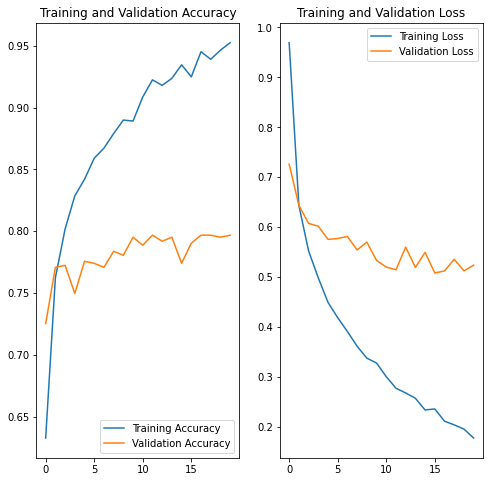

In [52]:
# Creating plots of loss and accuracy on the training and validation sets.
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(config.epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Fine-tuning for mobileNetV2

###Transfer Learning Model 2: InceptionV3 Model

Inception v3 is a convolutional neural network for assisting in image analysis and object detection, and got its start as a module for Googlenet. It is the third edition of Google's Inception Convolutional Neural Network, originally introduced during the ImageNet Recognition Challenge. Just as ImageNet can be thought of as a database of classified visual objects, Inception helps classification of objects in the world of computer vision.

In [53]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 6 classes
predictions = Dense(6, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

#freezing of the layers.
for layer in base_model.layers:
    layer.trainable = False

#Initialize wandb with your project name
run = wandb.init(project='maize-image-classification',save_code=True,name='inceptionV3',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.00001,
                     "epochs": 20,
                     "batch_size": 1024,
                     "loss_function": "sparse_categorical_crossentropy",
                     "architecture": "CNN four layers",
                     "dataset": "maize-images"
                 })
config = wandb.config  # We'll use this to configure our experiment

# # Initialize model like you usually do.
# tf.keras.backend.clear_session()
# model = Model()
# model.summary()

# Compile model like you usually do.
# Notice that we use config, so our metadata matches what gets executed
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
model.compile(optimizer, config.loss_function, metrics=['acc'])

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
# for layer in base_model.layers:
#     layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
# model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# train the model on the new data for a few epochs
model.fit(train_ds,
          epochs=config.epochs, 
          batch_size=config.batch_size,
          validation_data=(val_ds))

Epoch 1/20
77/77 [==============================] - 18s 162ms/step - loss: 10.0331 - acc: 0.3048 - val_loss: 5.1614 - val_acc: 0.4341
Epoch 2/20
77/77 [==============================] - 11s 141ms/step - loss: 4.1163 - acc: 0.4750 - val_loss: 4.0995 - val_acc: 0.4894
Epoch 3/20
77/77 [==============================] - 11s 140ms/step - loss: 3.3242 - acc: 0.5120 - val_loss: 3.6214 - val_acc: 0.5073
Epoch 4/20
77/77 [==============================] - 11s 141ms/step - loss: 2.8835 - acc: 0.5408 - val_loss: 3.3627 - val_acc: 0.5106
Epoch 5/20
77/77 [==============================] - 11s 141ms/step - loss: 2.5361 - acc: 0.5636 - val_loss: 3.1201 - val_acc: 0.5350
Epoch 6/20
77/77 [==============================] - 11s 140ms/step - loss: 2.2421 - acc: 0.5888 - val_loss: 2.8922 - val_acc: 0.5659
Epoch 7/20
77/77 [==============================] - 11s 141ms/step - loss: 2.0248 - acc: 0.6026 - val_loss: 2.8755 - val_acc: 0.5431
Epoch 8/20
77/77 [==============================] - 11s 141ms/step -

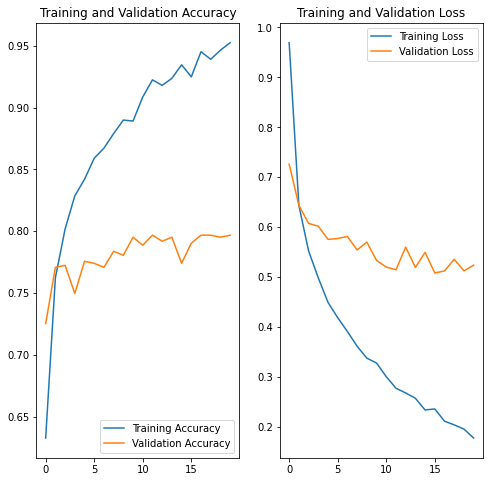

In [54]:
# Creating plots of loss and accuracy on the training and validation sets.
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(config.epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [55]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit(train_ds,
          epochs=12, 
          batch_size=32,
          validation_data=(val_ds))

0 input_8
1 conv2d_100
2 batch_normalization_94
3 activation_94
4 conv2d_101
5 batch_normalization_95
6 activation_95
7 conv2d_102
8 batch_normalization_96
9 activation_96
10 max_pooling2d_6
11 conv2d_103
12 batch_normalization_97
13 activation_97
14 conv2d_104
15 batch_normalization_98
16 activation_98
17 max_pooling2d_7
18 conv2d_108
19 batch_normalization_102
20 activation_102
21 conv2d_106
22 conv2d_109
23 batch_normalization_100
24 batch_normalization_103
25 activation_100
26 activation_103
27 average_pooling2d_9
28 conv2d_105
29 conv2d_107
30 conv2d_110
31 conv2d_111
32 batch_normalization_99
33 batch_normalization_101
34 batch_normalization_104
35 batch_normalization_105
36 activation_99
37 activation_101
38 activation_104
39 activation_105
40 mixed0
41 conv2d_115
42 batch_normalization_109
43 activation_109
44 conv2d_113
45 conv2d_116
46 batch_normalization_107
47 batch_normalization_110
48 activation_107
49 activation_110
50 average_pooling2d_10
51 conv2d_112
52 conv2d_114
53 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


77/77 [==============================] - 20s 189ms/step - loss: 1.6031 - accuracy: 0.3917 - val_loss: 1.4490 - val_accuracy: 0.4634
Epoch 2/12
77/77 [==============================] - 13s 170ms/step - loss: 1.2579 - accuracy: 0.6026 - val_loss: 1.2132 - val_accuracy: 0.5577
Epoch 3/12
77/77 [==============================] - 13s 171ms/step - loss: 1.0856 - accuracy: 0.6709 - val_loss: 1.0936 - val_accuracy: 0.6146
Epoch 4/12
77/77 [==============================] - 13s 170ms/step - loss: 0.9664 - accuracy: 0.7091 - val_loss: 1.0236 - val_accuracy: 0.6374
Epoch 5/12
77/77 [==============================] - 13s 169ms/step - loss: 0.8747 - accuracy: 0.7448 - val_loss: 0.9977 - val_accuracy: 0.6341
Epoch 6/12
77/77 [==============================] - 13s 170ms/step - loss: 0.7996 - accuracy: 0.7680 - val_loss: 0.9545 - val_accuracy: 0.6634
Epoch 7/12
77/77 [==============================] - 13s 169ms/step - loss: 0.7352 - accuracy: 0.7883 - val_loss: 0.9189 - val_accuracy: 0.6602
Epoch 8/12

####MobileNetV2 another way.

In [67]:
## Create the base model from the pre-trained model MobileNet V2

image_size=(img_height, img_width)
IMG_SHAPE = image_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
#freezing
for layer in base_model.layers:
  base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)


model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

#Initialize wandb with your project name
run = wandb.init(project='maize-image-classification',save_code=True,name='MobileNetV2 another way',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.0001,
                     "epochs": 20,
                     "batch_size": 1024,
                     "loss_function": "BinaryCrossentropy",
                     "architecture": "CNN four layers",
                     "dataset": "maize-images"
                 })
config = wandb.config


optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
model.compile(optimizer, config.loss_function, metrics=['acc'])

# base_learning_rate = 0.0001
# model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# validation_steps=20
# initial_epochs = 20

# loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

hist= model.fit(train_ds,
          epochs=config.epochs, 
          batch_size=config.batch_size,
          validation_data=(val_ds))

Epoch 1/20
77/77 [==============================] - 10s 87ms/step - loss: -10.3353 - acc: 0.1694 - val_loss: -17.0501 - val_acc: 0.1740
Epoch 2/20
77/77 [==============================] - 6s 74ms/step - loss: -19.0032 - acc: 0.1950 - val_loss: -19.5007 - val_acc: 0.1772
Epoch 3/20
77/77 [==============================] - 6s 73ms/step - loss: -20.2566 - acc: 0.1967 - val_loss: -19.7315 - val_acc: 0.1772
Epoch 4/20
77/77 [==============================] - 6s 74ms/step - loss: -20.5813 - acc: 0.1975 - val_loss: -20.1582 - val_acc: 0.1772
Epoch 5/20
77/77 [==============================] - 6s 75ms/step - loss: -20.8557 - acc: 0.1975 - val_loss: -20.6540 - val_acc: 0.1789
Epoch 6/20
77/77 [==============================] - 6s 74ms/step - loss: -21.1898 - acc: 0.1975 - val_loss: -20.8123 - val_acc: 0.1789
Epoch 7/20
77/77 [==============================] - 6s 74ms/step - loss: -21.3024 - acc: 0.1975 - val_loss: -20.9491 - val_acc: 0.1789
Epoch 8/20
77/77 [==============================] - 6s

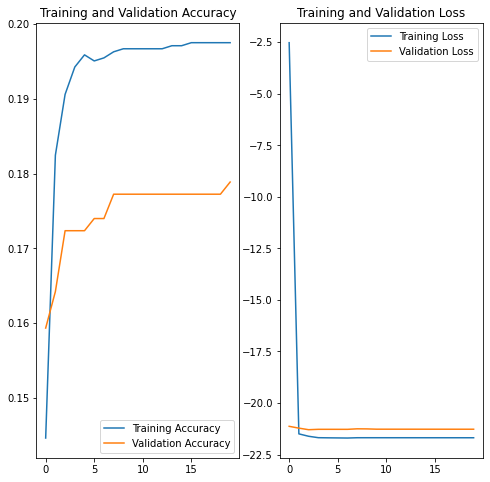

In [57]:
# Creating plots of loss and accuracy on the training and validation sets.
acc = hist.history['acc']
val_acc = hist.history['val_acc']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(config.epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###Transfer Learning Model 3: Resnet

In [63]:
##
image_size=(img_height, img_width)
IMG_SHAPE = image_size + (3,)
base_model = tf.keras.applications.ResNet152(weights = 'imagenet',
                                             include_top = False,
                                             input_shape = IMG_SHAPE)

#adding the top
x = layers.Flatten()(base_model.output)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(6, activation = 'softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

#freezing the layer.
for layer in base_model.layers:
  layer.trainable = False

#initializing our project with wandb.
run = wandb.init(project='maize-image-classification',save_code=True,name='ResNet152',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.0001,
                     "epochs": 20,
                     "batch_size": 32,
                     "loss_function": "sparse_categorical_crossentropy",
                     "architecture": "CNN four layers",
                     "dataset": "maize-images"
                 })
config = wandb.config

#compiling our model.
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
model.compile(optimizer, config.loss_function, metrics=['acc'])



#train the model 
hist= model.fit(train_ds,
          epochs=config.epochs, 
          batch_size=config.batch_size,
          validation_data=(val_ds))


Epoch 1/20
77/77 [==============================] - 53s 535ms/step - loss: 1.4364 - acc: 0.8127 - val_loss: 0.5743 - val_acc: 0.8618
Epoch 2/20
77/77 [==============================] - 38s 493ms/step - loss: 0.1242 - acc: 0.9630 - val_loss: 0.5764 - val_acc: 0.8553
Epoch 3/20
77/77 [==============================] - 38s 491ms/step - loss: 0.0713 - acc: 0.9813 - val_loss: 0.6232 - val_acc: 0.8634
Epoch 4/20
77/77 [==============================] - 38s 491ms/step - loss: 0.0769 - acc: 0.9781 - val_loss: 0.7218 - val_acc: 0.8764
Epoch 5/20
77/77 [==============================] - 38s 490ms/step - loss: 0.0769 - acc: 0.9817 - val_loss: 0.6800 - val_acc: 0.8862
Epoch 6/20
77/77 [==============================] - 38s 490ms/step - loss: 0.0769 - acc: 0.9874 - val_loss: 0.7886 - val_acc: 0.8634
Epoch 7/20
77/77 [==============================] - 38s 491ms/step - loss: 0.0532 - acc: 0.9874 - val_loss: 0.6843 - val_acc: 0.8813
Epoch 8/20
77/77 [==============================] - 38s 491ms/step - 

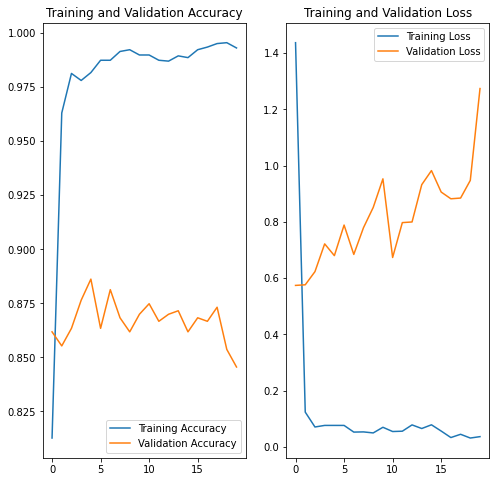

In [64]:
# Creating plots of loss and accuracy on the training and validation sets.
acc = hist.history['acc']
val_acc = hist.history['val_acc']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(config.epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()